# Data and Problem Description

Source: [Building Sites Power Consumption](https://www.kaggle.com/datasets/arashnic/building-sites-power-consumption-dataset). If you use the data, please refer [this site](https://github.com/Kaggle/kaggle-api#api-credentials) in generating API token like `kaggle.json`.

More accurate forecasts of building energy consumption mean better planning and more efficient energy use. So The objective is to forecast energy consumption from following data:
(For each data set, several test periods over which a forecast is required will be specified.)

## Historical Consumption
A selected time series of consumption data for over 260 buildings.

- `obs_id` - An arbitrary ID for the observationaa
- `SiteId` - An arbitrary ID number for the building, matches across datasets
- `ForecastId` - An ID for a timeseries that is part of a forecast (can be matched with the submission file)
- `Timestamp` - The time of the measurement
- `Value` - A measure of consumption for that building

## Building Metadata
Additional information about the included buildings.

- `SiteId` - An arbitrary ID number for the building, matches across datasets
- `Surface` - The surface area of the building
- `Sampling` - The number of minutes between each observation for this site. The timestep size for each ForecastId can be found in the separate "Submission Forecast Period" file on the data download page.
- `BaseTemperature` - The base temperature for the building
- `IsDayOff` - True if DAYOFWEEK is not a work day

## Historical Weather Data
This dataset contains temperature data from several stations near each site. For each site several temperature measurements were retrieved from stations in a radius of 30 km if available. Note: Not all sites will have available weather data.

Note: Weather data is available for test periods under the assumption that reasonably accurate forecasts will be available to algorithms that the time that we are attempting to make predictions about the future.

- `SiteId` - An arbitrary ID number for the building, matches across datasets
- `Timestamp` - The time of the measurement
- `Temperature` - The temperature as measured at the weather station
- `Distance` - The distance in km from the weather station to the building in km

## Public Holidays
Public holidays at the sites included in the dataset, which may be helpful for identifying days where consumption may be lower than expected.Note: Not all sites will have available public holiday data.

- `SiteId` - An arbitrary ID number for the building, matches across datasets
- `Date` - The date of the holiday
- `Holiday` - The name of the holiday

## Acknowledgements
Forecasting energy consumption data published by Schneider Electric.

## Inspiration
Three time horizons and time steps are distinguished for more than 260 building sites are provided. The goal is either:

- To forecast the consumption for each quarter for the length of time specified by the submission format.
- To forecast the consumption for each hour for the length of time specified by the submission format.
- To forecast the consumption for each day for the length of time specified by the submission format.

Historical data are given at the granularity that is required for the consumption forecast. So, when historical data are given by steps of 15 minutes, forecasts are required by steps of 15 minutes. When historical data are given by steps of 1 hour, forecasts are required by steps of 1 hour. When historical data are given by steps of 1 day, forecasts are required by steps of 1 day.

# EDA

In [4]:
!kaggle datasets download -d arashnic/building-sites-power-consumption-dataset
!unzip building-sites-power-consumption-dataset.zip -d ./dataset

building-sites-power-consumption-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  building-sites-power-consumption-dataset.zip
  inflating: ./dataset/power-laws-forecasting-energy-consumption-holidays.csv  
  inflating: ./dataset/power-laws-forecasting-energy-consumption-metadata.csv  
  inflating: ./dataset/power-laws-forecasting-energy-consumption-submission-forecast-period.csv  
  inflating: ./dataset/power-laws-forecasting-energy-consumption-test-data.csv  
  inflating: ./dataset/power-laws-forecasting-energy-consumption-training-data.csv  
  inflating: ./dataset/power-laws-forecasting-energy-consumption-weather.csv  


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [6]:
holidays = pd.read_csv("dataset/power-laws-forecasting-energy-consumption-holidays.csv", sep=";", parse_dates=["Date"])
print("Holiday Columns: ", list(holidays.columns))
print("NaNs:", holidays.isna().sum().values)

metadata = pd.read_csv("dataset/power-laws-forecasting-energy-consumption-metadata.csv", sep=";")
print("Metadata Columns: ", list(metadata.columns))
print("NaNs:", metadata.isna().sum().values)

weather = pd.read_csv("dataset/power-laws-forecasting-energy-consumption-weather.csv", sep=";", parse_dates=["Timestamp"])
print("Weather Columns: ", list(weather.columns))
print("NaNs:", weather.isna().sum().values)

train_data = pd.read_csv("dataset/power-laws-forecasting-energy-consumption-training-data.csv", sep=";", parse_dates=["Timestamp"])
print("Train Columns: ", list(train_data.columns))
print("NaNs:", train_data.isna().sum().values)
# #test_data = pd.read_csv("dataset/power-laws-forecasting-energy-consumption-test-data.csv")

Holiday Columns:  ['Date', 'Holiday', 'SiteId']
NaNs: [0 0 0]
Metadata Columns:  ['SiteId', 'Surface', 'Sampling', 'BaseTemperature', 'MondayIsDayOff', 'TuesdayIsDayOff', 'WednesdayIsDayOff', 'ThursdayIsDayOff', 'FridayIsDayOff', 'SaturdayIsDayOff', 'SundayIsDayOff']
NaNs: [0 0 0 0 0 0 0 0 0 0 0]
Weather Columns:  ['Timestamp', 'Temperature', 'Distance', 'SiteId']
NaNs: [0 0 0 0]
Train Columns:  ['obs_id', 'SiteId', 'Timestamp', 'ForecastId', 'Value']
NaNs: [    0     0     0     0 86601]


In [7]:
pd.DataFrame([{"name": k, "NaNs": v.isna().sum().values, "Columns": list(v.columns)} for k, v in {"Holidays": holidays, "Metadata": metadata, "Weather": weather, "TrainData": train_data}.items()])

,name,NaNs,Columns
0,Holidays,"[0, 0, 0]","[Date, Holiday, SiteId]"
1,Metadata,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[SiteId, Surface, Sampling, BaseTemperature, M..."
2,Weather,"[0, 0, 0, 0]","[Timestamp, Temperature, Distance, SiteId]"
3,TrainData,"[0, 0, 0, 0, 86601]","[obs_id, SiteId, Timestamp, ForecastId, Value]"


## Top Rows

In [8]:
holidays.head()

,Date,Holiday,SiteId
0,2016-02-15,Washington's Birthday,1
1,2017-05-29,Memorial Day,1
2,2017-11-23,Thanksgiving Day,1
3,2017-12-29,New Years Eve Shift,1
4,2017-12-31,New Years Eve,1


In [9]:
metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,207,7964.873347,30.0,18.0,False,False,False,False,False,True,True
1,7,15168.125971,30.0,18.0,False,False,False,False,False,True,True
2,74,424.340663,15.0,18.0,False,False,False,False,False,True,True
3,239,1164.822636,15.0,18.0,False,False,False,False,False,True,True
4,274,1468.246690,5.0,18.0,False,False,False,False,False,True,True


In [10]:
weather.head()

,Timestamp,Temperature,Distance,SiteId
0,2017-03-03 19:00:00+00:00,10.6,27.489346,51
1,2017-03-03 19:20:00+00:00,11.0,28.663082,51
2,2017-03-03 20:00:00+00:00,6.3,28.307039,51
3,2017-03-03 21:55:00+00:00,10.0,29.797449,51
4,2017-03-03 23:00:00+00:00,5.4,28.307039,51


In [11]:
train_data.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,4852050,42,2016-10-18 02:45:00+00:00,1087,26397.049623
1,1638923,42,2016-10-18 11:45:00+00:00,1087,42958.364641
2,5748910,42,2016-10-18 20:45:00+00:00,1087,27096.919666
3,38199,42,2016-10-20 10:45:00+00:00,1087,50211.408087
4,1338204,42,2016-10-20 18:45:00+00:00,1087,50503.305105


## Train Data

<AxesSubplot:ylabel='Frequency'>

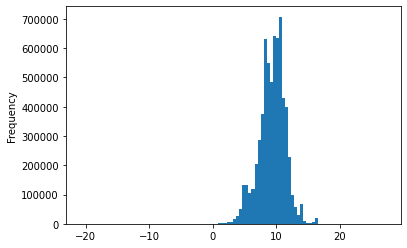

In [12]:
pd.Series(np.log(train_data['Value']+0.000000001)).plot.hist(bins=100)

In [13]:
train_data.describe()

,obs_id,SiteId,ForecastId,Value
count,6.559830e+06,6.559830e+06,6.559830e+06,6.473229e+06
mean,3.935106e+06,1.620964e+02,3.482184e+03,3.560104e+05
std,2.271511e+06,9.392171e+01,2.009486e+03,3.309454e+08
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.968046e+06,8.700000e+01,1.744000e+03,3.492465e+03
50%,3.935262e+06,1.730000e+02,3.489000e+03,1.408683e+04
75%,5.901983e+06,2.370000e+02,5.216000e+03,4.649371e+04
max,7.869005e+06,3.050000e+02,6.974000e+03,6.404683e+11


### Unique Sites

In [14]:
print("Train Data", len(train_data.SiteId.unique()))
print("Weather", len(weather.SiteId.unique()))
print("Holidays", len(holidays.SiteId.unique()))

common_sites = list(set(holidays.SiteId.unique()) & set(weather.SiteId.unique()) & set(train_data.SiteId.unique()))
print("Common in All", len(common_sites))
print("Common in All Sites", common_sites)

Train Data 267
Weather 49
Holidays 227
Common in All 29
Common in All Sites [12, 13, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 29, 32, 33, 34, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 57]


In [15]:
def stats_per_site(df):
    return pd.DataFrame(
        [{
            "SiteId": site, 
            "Years": np.sort(df[(df.SiteId == site)].Timestamp.dt.year.unique()), 
            "Min Timestamp": df[(df.SiteId == site)].Timestamp.min(),
            "Max Timestamp": df[(df.SiteId == site)].Timestamp.max(), 
            "Samples": df[(df.SiteId == site)].count().sum()
            } for site in df.SiteId.unique()]
    ).sort_values("Samples", ascending=False)

### Sites with most data (among Common Sites)

In [16]:
stats_per_site(train_data[(train_data.SiteId.isin(common_sites))]).merge(metadata[["SiteId", "Sampling"]], on="SiteId")

,SiteId,Years,Min Timestamp,Max Timestamp,Samples,Sampling
0,33,"[2014, 2015, 2016, 2017]",2014-06-25 12:30:00+00:00,2017-10-09 16:15:00+00:00,481382,10.0
1,22,"[2014, 2015, 2016, 2017]",2014-10-01 12:10:00+00:00,2017-11-04 09:55:00+00:00,448813,10.0
2,25,"[2014, 2015, 2016, 2017]",2014-12-19 15:30:00+00:00,2017-10-18 05:15:00+00:00,413033,15.0
3,50,"[2015, 2016, 2017]",2015-11-18 18:45:00+00:00,2017-11-08 06:30:00+00:00,289020,15.0
4,49,"[2015, 2016, 2017]",2015-11-19 19:15:00+00:00,2017-11-09 07:00:00+00:00,288534,15.0
5,46,"[2016, 2017]",2016-01-05 08:30:00+00:00,2017-10-14 14:15:00+00:00,260156,15.0
6,16,"[2014, 2015, 2016, 2017]",2014-09-23 12:15:00+00:00,2017-11-14 11:15:00+00:00,115494,15.0
7,27,"[2014, 2015, 2016, 2017]",2014-11-28 16:45:00+00:00,2017-10-15 07:45:00+00:00,105899,15.0
8,26,"[2014, 2015, 2016, 2017]",2014-11-27 14:00:00+00:00,2017-10-14 05:00:00+00:00,105634,15.0
9,40,"[2015, 2016, 2017]",2015-07-03 14:30:00+00:00,2017-11-08 13:30:00+00:00,86637,10.0


### Sites with Most Data (Overall)

In [17]:
stats_per_site(train_data).merge(metadata[["SiteId", "Sampling"]], on="SiteId")

,SiteId,Years,Min Timestamp,Max Timestamp,Samples,Sampling
0,302,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",2009-12-31 12:15:00+00:00,2017-08-23 04:00:00+00:00,1118212,15.0
1,261,"[2012, 2013, 2014, 2015, 2016, 2017]",2012-06-01 00:15:00+00:00,2017-10-01 18:00:00+00:00,778891,15.0
2,6,"[2013, 2014, 2015, 2016, 2017]",2013-01-01 01:00:00+00:00,2017-10-23 02:45:00+00:00,702692,30.0
3,269,"[2013, 2014, 2015, 2016, 2017]",2013-05-30 09:15:00+00:00,2017-10-03 21:00:00+00:00,635362,5.0
4,271,"[2013, 2014, 2015, 2016, 2017]",2013-07-09 17:40:00+00:00,2017-10-20 03:25:00+00:00,625687,5.0
...,...,...,...,...,...,...
262,47,"[2015, 2016]",2015-11-11 00:00:00+00:00,2016-11-04 00:00:00+00:00,1797,15.0
263,94,"[2015, 2016]",2015-07-01 00:00:00+00:00,2016-06-24 00:00:00+00:00,1794,15.0
264,272,"[2015, 2016]",2015-09-15 00:05:00+00:00,2016-09-08 00:05:00+00:00,1793,5.0
265,163,[2014],2014-01-02 00:00:00+00:00,2014-12-27 00:00:00+00:00,1789,15.0


## Weekends Info

In [18]:
print(f"MondayIsDayOff: {metadata['MondayIsDayOff'].astype(int).sum()}")
print(f"TuesdayIsDayOff: {metadata['TuesdayIsDayOff'].astype(int).sum()}")
print(f"WednesdayIsDayOff: {metadata['WednesdayIsDayOff'].astype(int).sum()}")
print(f"ThursdayIsDayOff: {metadata['ThursdayIsDayOff'].astype(int).sum()}")
print(f"FridayIsDayOff: {metadata['FridayIsDayOff'].astype(int).sum()}")
print(f"SaturdayIsDayOff: {metadata['SaturdayIsDayOff'].astype(int).sum()}")
print(f"SundayIsDayOff: {metadata['SundayIsDayOff'].astype(int).sum()}")

MondayIsDayOff: 0
TuesdayIsDayOff: 0
WednesdayIsDayOff: 0
ThursdayIsDayOff: 0
FridayIsDayOff: 1
SaturdayIsDayOff: 254
SundayIsDayOff: 258


## Data sampling by time
The number of minutes between each observation for this site.

In [19]:
metadata.groupby("Sampling").count()[["SiteId"]].rename(columns={"SiteId": "Number of Sites"}, ).rename_axis("Sampling (mins)", axis='index')

,Number of Sites
Sampling (mins),
5.0,27
10.0,15
15.0,212
30.0,13


## Unusual Sites

Site 26: Meter Reading=0 after October'16 

<AxesSubplot:xlabel='Timestamp'>

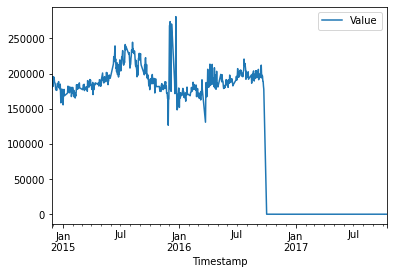

In [20]:
train_data.groupby("SiteId") \
              .apply(lambda group: group.set_index('Timestamp').resample("D").interpolate(method="time")) \
              .reset_index(level=1) \
              .reset_index(drop=True).dropna(subset=["Value"]).groupby("SiteId").get_group(26).plot(x="Timestamp", y="Value")

## Feature Correlation

In [21]:

def merge_holidays_by_date(final_df, holidays):
    """Merge Holiday df with the train df"""
    holidays_df = holidays.copy()
    data_df = final_df.copy()

    holidays_df['dateKey'] = holidays_df.Date.dt.year.astype(str) + holidays_df.Date.dt.month.astype(str) + holidays_df.Date.dt.day.astype(str)
    data_df['dateKey'] = data_df.Timestamp.dt.year.astype(str) + data_df.Timestamp.dt.month.astype(str) + data_df.Timestamp.dt.day.astype(str)

    temp_df_cols = data_df.columns.tolist() + ['Holiday']
    temp_df_cols.remove('dateKey')

    temp_df = pd.merge(data_df, holidays_df, how="left", on=["dateKey", "SiteId"], )[temp_df_cols]
    temp_df['Holiday'] = (~temp_df['Holiday'].isna()).astype(int)

    return temp_df

def merge_site_leaves(final_df, metadata):
    """Merge Site Weekend data with train df"""
    data_df = final_df.copy()

    # Sites only had weekly leaves on Friday, Saturday and Sunday
    friday_leave = final_df.Timestamp.dt.dayofweek == 4 & final_df.SiteId.isin(metadata[metadata['FridayIsDayOff']]['SiteId'])
    saturday_leave = final_df.Timestamp.dt.dayofweek == 5 & final_df.SiteId.isin(metadata[metadata['SaturdayIsDayOff']]['SiteId'])
    sunday_leave = final_df.Timestamp.dt.dayofweek == 6 & final_df.SiteId.isin(metadata[metadata['SundayIsDayOff']]['SiteId'])
    site_leave = friday_leave | saturday_leave | sunday_leave

    data_df['Holiday'] = (data_df['Holiday'] | site_leave).astype("int8")

    return data_df

def merge_weather(final_df, weather):
    """Merge weather data into the train df"""
    data_df = final_df.copy()

    # drop duplicate values in weather and pick the closest weather station
    weather_cleaned = weather.sort_values(["SiteId", "Timestamp", "Distance"]).groupby(["SiteId", "Timestamp"]).first().reset_index()
    assert weather_cleaned.groupby(["SiteId", "Timestamp"]).count().max().max() == 1

    data_df = pd.merge_asof(data_df.sort_values(["Timestamp"]), weather_cleaned.sort_values(["Timestamp"]), on="Timestamp", by="SiteId", direction="nearest")

    return data_df

def resample_train_data(final_df, sampling="D"):
    """Resample the data to a particular frequency"""
    return final_df.groupby("SiteId") \
              .apply(lambda group: group.drop_duplicates(["Timestamp"]).set_index("Timestamp").resample(sampling).interpolate(method="time")) \
              .reset_index(level=1) \
              .reset_index(drop=True) \
              .dropna(subset=["Value"])

def calculate_degree_days(train_df):
    """Calculate the Degree Days Heating and Cooling values"""
    data_df = train_df.copy()

    data_df['DDCTemperature'] = (data_df['Temperature'] - data_df['BaseTemperature']).clip(lower=0)
    data_df['DDHTemperature'] = (data_df['BaseTemperature'] - data_df['Temperature']).clip(lower=0)

    return data_df

In [22]:
site_data = train_data[train_data.SiteId == 33]
site_data.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
718490,3358305,33,2014-09-24 17:45:00+00:00,888,28280.900462
718491,2728591,33,2014-09-25 02:00:00+00:00,888,19673.669886
718492,5536544,33,2014-09-25 09:00:00+00:00,888,27051.296094
718493,4386824,33,2014-09-25 11:45:00+00:00,888,28280.900462
718494,7331131,33,2014-09-25 14:30:00+00:00,888,27051.296094


In [23]:
site_data = merge_holidays_by_date(site_data, holidays)
site_data = merge_site_leaves(site_data, metadata)
site_data = merge_weather(site_data, weather)
site_data = resample_train_data(site_data)

In [24]:
site_data = pd.merge(site_data, metadata[["SiteId", "Surface", "BaseTemperature"]], how="left", on=["SiteId"])

In [25]:
# Aggregate Train data on Weekly granularity.

train_agg_df = site_data.groupby(['SiteId', site_data.Timestamp.dt.year, site_data.Timestamp.dt.isocalendar().week]).agg({
    'SiteId': 'first', 
    'Timestamp': 'first', 
    'Value': 'sum', 
    'Holiday': 'sum', 
    'Surface': 'first', 
    'BaseTemperature': 'first', 
    'Temperature': 'mean'
  }).reset_index(drop=True)

In [26]:
train_agg_df = calculate_degree_days(train_agg_df)

In [27]:
train_cols = ['Holiday', 'DDHTemperature', 'DDCTemperature', "Value"]

In [28]:
train_agg_df[train_cols].describe()

,Holiday,DDHTemperature,DDCTemperature,Value
count,176.000000,176.000000,176.000000,176.000000
mean,2.090909,7.661014,0.351691,150228.310925
std,0.768800,6.586032,0.966728,32511.934404
min,0.000000,0.000000,0.000000,17214.461151
25%,2.000000,0.935714,0.000000,132797.271733
50%,2.000000,7.150000,0.000000,145093.315412
75%,2.333333,12.659524,0.000000,159848.567826
max,4.000000,26.371429,4.628571,254937.972277


In [29]:
train_agg_df[train_cols].corr()

,Holiday,DDHTemperature,DDCTemperature,Value
Holiday,1.000000,-0.014743,-0.060459,0.054492
DDHTemperature,-0.014743,1.000000,-0.425593,0.510575
DDCTemperature,-0.060459,-0.425593,1.000000,-0.078656
Value,0.054492,0.510575,-0.078656,1.000000


<AxesSubplot:>

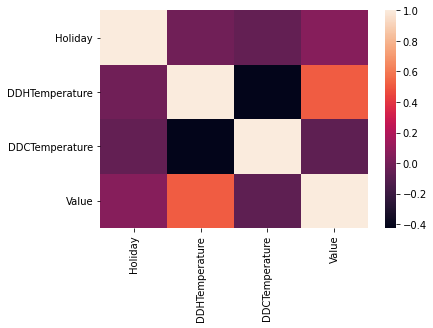

In [30]:
sns.heatmap(train_agg_df[train_cols].corr())

## Production Volumes Data Synthesis

Production Volumes from SAP MARA Table were a key feature during prediction of Energy Consumption for the customer. Unfortunately this data was avaiable in the kaggle dataset, hence the data in the MARA table was synthesised for the purpose of this accelerator.

The synthesised data mocks the format of data from MARA Table in SAP.

In [31]:
def generate_prod_vols(site_data, target_corr=0.6):
    """ Sample Production Volumes Per Site """

    site_values = site_data.Value.values
    sample_shape = site_values.shape
    site_data_mean = np.mean(site_values)
    site_data_std = np.std(site_values)

    for additional_variance in np.logspace(0, 5, 1000):
        noise = np.random.normal(site_data_mean, site_data_std * additional_variance, size=sample_shape)
        prod_vol = np.abs(site_values + noise).astype(np.int32)
        corr = np.corrcoef(site_values, prod_vol)[0, 1]

        if np.isclose(corr, target_corr, atol=0.05):
            break

    return prod_vol, corr, additional_variance

def generate_numbers_from_sum(nums, total_sum):
    """Generate `nums` random numbers which have sum of `total_sum` """
    multiplier = nums/10

    distribution = (np.random.standard_exponential((total_sum,)) * multiplier + 1).astype(np.int32)
    unique, counts = np.unique(distribution, return_counts=True)

    return unique, counts

def generate_mara_table(site_data):
    """ Generate MARA SAP Table """
    prod_vol, _, _ = generate_prod_vols(site_data.dropna(subset=["Value"]))
    mara_table = []
    for siteId, timestamp, vol in zip(site_data.SiteId, site_data.Timestamp, prod_vol):
        materialnums, materialvols = generate_numbers_from_sum(50, vol)
        for materialnum, materialvol in zip(materialnums, materialvols):
            row = [timestamp, siteId, materialnum, f"Material: {materialnum}", materialvol]
            mara_table.append(row)
        # print(len(unique), sum(counts[:50]), vol)

    mara_df = pd.DataFrame(mara_table, columns=["POSTINGDATE", "PLANT", "MATERIALNUM", "MATERIALDESC", "VOLMANUFACTUREDGOODS"])
    return mara_df

In [32]:
# Sites with most data
top_sites = [33.0, 17.0, 18.0, 13.0, 26.0]

In [33]:
mara_table = []
for siteId, site_data in train_data[train_data.SiteId.isin(top_sites)].groupby("SiteId"):
    mara_table.append(generate_mara_table(site_data))
    print("Done", siteId)

In [ ]:
pd.concat(mara_table).to_parquet("dataset/mara_table.parquet", index=False)